In [2]:
import numpy as np
import requests
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import time
import requests
import time

token = 'm3lB5Q8zHn7wis2frICKXcmPb7yERygZnPypvcjuKPcye4IKkwdY'
base_url = 'https://api.lens.org/scholarly/search'


In [ ]:
lens_id_query_art = {
 "query": {
   "bool": {
     "must": [{
       "terms": {
         "lens_id": lens_id_list
       }},
       {"bool": {
         "must": [
           {"term": {"publication_type": "journal article"}},
         ]
       }
       }
     ]
   }
 }
}

lens_id_query_conf = {
 "query": {
   "bool": {
     "must": [{
       "terms": {
         "lens_id": lens_id_list
       }},
       {"bool": {
         "must": [
           {"term": {"publication_type": "conference proceedings"}},
         ]
       }
       }
     ]
   }
 }
}

In [ ]:
lens_id_query2 = {
           "terms":{
                "lens_id": lens_id_list
           }
     }

In [ ]:
headers = {'Authorization': token, 'Content-Type': 'application/json'}
response = requests.post(base_url, json=lens_id_query, headers=headers)
if response.status_code != requests.codes.ok:
    print(response.status_code)
else:
    json_data = json.loads(response.text)
    print(len(json_data['data']))
json_data['data'][2]

### Start Here With Filtering Out Irrelevant Items

In [3]:
orig_data = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/raw_query_manual_clean.csv',index_col=0)
rel_data = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/raw_query_short.csv',index_col=0)
id_keep_list = rel_data.index.tolist()

data = orig_data[orig_data.index.isin(id_keep_list)==True]


In [4]:

# there are some in the shortlist that are not in the long list but should be kept...
# print titles to review whether they are relevant or not like I did in the manual cleaning step
data_missing = rel_data[rel_data.index.isin(data.index.tolist())==False]

for title in data_missing.Title.tolist():
    print(f'--> {title}')



--> Effect of electrochromic windows on energy consumption of high-rise office buildings in different climate regions of Iran
--> Dataset for the Solar Incident Radiation and Electricity Production BIPV/BAPV System on the Northern/Southern Façade in Dense Urban Areas
--> Parameter evaluation and performance analysis of a BIPVT system for the different climates of India: A comprehensive study
--> Metal halide perovskite-based flexible tandem solar cells: next-generation flexible photovoltaic technology
--> Comparison of Solar Glazing Performance of Semi-transparent Amorphous-Silicon (a-Si) and Crystalline-Silicon (c-Si) Photovoltaic Panels: A Case Study for Typical Office Building in Hong Kong
--> Comportamiento en operación real de la tecnología PV de capa fina (a-Si) en aplicaciones para la edificación (BIPV)
--> Comparison Between an Interleaved Boost Converter Using Si MOSFETs Versus GaN HEMTs
--> 스마트 조명과 BIPV시스템을 이용한 조명에너지 절감효과 연구
--> A review on developments and researches of buil

In [7]:

all_data = pd.concat([data,data_missing])
all_data.columns


Index(['Remove', 'Title', 'Date Published', 'Publication Year',
       'Publication Type', 'Source Title', 'ISSNs', 'Publisher',
       'Source Country', 'Author/s', 'Abstract', 'Volume', 'Issue Number',
       'Start Page', 'End Page', 'Fields of Study', 'Keywords', 'MeSH Terms',
       'Chemicals', 'Funding', 'Source URLs', 'External URL', 'PMID', 'DOI',
       'Microsoft Academic ID', 'PMCID', 'Citing Patents Count', 'References',
       'Citing Works Count'],
      dtype='object')

In [9]:

# create the query based on the id list from the relevant data
lens_id_list = all_data.index.tolist()
lens_id_query = {
           "terms":{
                "lens_id": lens_id_list
           }
     }

len(lens_id_list)

3544

In [ ]:
# request body with scroll time of 1 minute
request_body = {
     "query": lens_id_query,
     "size": 1000,
     "scroll":"1m",
}
headers = {'Authorization': token, 'Content-Type': 'application/json'}

# Recursive function to scroll through paginated results
def scroll(scroll_id):
    # Change the request_body to prepare for next scroll api call
    # Make sure to append the include fields to make faster response
    if scroll_id is not None:
        global request_body
        request_body = {"scroll_id": scroll_id}

    # make api request
    response = requests.post(url, json=request_body, headers=headers) 

    # If rate-limited, wait for n seconds and proceed the same scroll id
    # Since scroll time is 1 minutes, it will give sufficient time to wait and proceed
    if response.status_code == requests.codes.too_many_requests:
        time.sleep(8)
        scroll(scroll_id)
    # If the response is not ok here, better to stop here and debug it
    elif response.status_code != requests.codes.ok:
        print(response.json())
    # If the response is ok, do something with the response, take the new scroll id and iterate
    else:
        json_data = response.json()
        scroll_id = json_data['scroll_id'] # Extract the new scroll id from response

        print('Saving')
        idnumber = json_data['data'][0]['lens_id']
        json.dump(json_data,open(f'/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/dump_{idnumber}.json','w'))

        scroll(scroll_id)

# start recursive scrolling
scrolled = scroll(scroll_id=None)


## Move to Compiling and Cleaning

In [228]:
# write function to grab data from a single entry

def get_data(data,field):
    try:
        if field=='authors':
            try:
                value = 'org_' + str(data[field][0]['affiliations'][0]['name'])
            except KeyError:
                id_type = data[field][0]['ids'][0]['type']
                id_value = data[field][0]['ids'][0]['value']
                value = str(id_type) + '_' + str(id_value)
        elif field=='year_published':
            try:
                value = data[field]
            except KeyError:
                try:
                    value = data['date_published_parts'][0]
                except KeyError:
                    try:
                        value = data['created'].split('-')[0]
                    except KeyError:
                        value = 'none'
        else:
            try:
                value = data[field]
            except KeyError:
                value = 'none'
    except KeyError:
        value = 'none'
    
    return value




def extract_fields(data):
    data_dict = dict()
    data_dict['lens_id'] = get_data(data,'lens_id')
    data_dict['document_type'] = get_data(data,'publication_type')
    data_dict['title'] = get_data(data,'title')
    data_dict['abstract'] = get_data(data,'abstract')
    data_dict['affiliation'] = get_data(data,'authors')
    data_dict['pub_year'] = get_data(data,'year_published')
    data_dict['keywords'] = get_data(data,'fields_of_study')
    data_dict['keywords_count'] = len(get_data(data,'fields_of_study'))
    data_dict['language'] = get_data(data,'languages')[0]
    return data_dict

In [229]:
# create file list 
files = glob.glob("/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/*.json")

# write function to create dataframe for each file
def parsejsons(current_file):
    with open(current_file) as jsonFile:
        json_str = jsonFile.read()
        json_data = json.loads(json_str)
        data_list = []
        # get_data(data,'abstract')
        for i in list(range(0,len(json_data['data']))):
            data_list.append(extract_fields(json_data['data'][i]))

        return pd.DataFrame(data_list)



In [230]:
#extract and concat all data into one frame
df_list = []

for i in files:
    df_list.append(parsejsons(i))

all_data = pd.concat(df_list)
print(len(all_data))

6958


In [231]:
all_data.to_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/lit_dataset_all.csv',index=False)

## Filter Down Dataframe

In [8]:
# print the length difference in the original dataframe and the shorter query


print(f'Original shape was {orig_data.shape}')
print(f'New shape is {rel_data.shape}')

Index(['document_type', 'title', 'abstract', 'affiliation', 'pub_year',
       'keywords', 'keywords_count', 'language'],
      dtype='object')

In [ ]:

# there are some in the shortlist that are not in the long list but should be kept...
# print titles to review whether they are relevant or not like I did in the manual cleaning step
data_missing = raw_short_data[raw_short_data.index.isin(data.index.tolist())==False]

for title in data_missing.Title.tolist():
    print(f'--> {title}')



In [ ]:

all_data = pd.concat([data,data_missing])
all_data.columns


4892


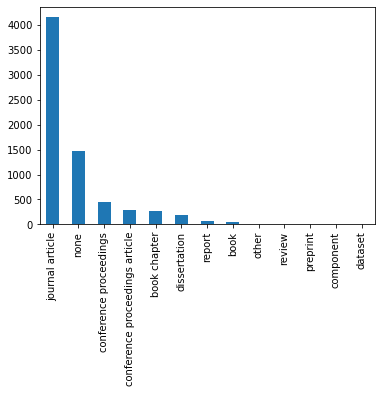

In [9]:
# UNRELATED
# remove the irrelevant items

not_relevant = all_data[all_data['Remove']==True].index.tolist()

all_data_rel = all_data[all_data.index.isin(not_relevant)==False]

print(f'Original shape was {all_data.shape}')
print(f'New shape is {all_data_rel.shape}')

In [ ]:
# PUBLICATION TYPE
# remove the non peer reviewed documents

pd.value_counts(all_data_rel['Publication Type']).plot.bar()

all_data_peer = all_data_rel[(all_data_rel['Publication Type']=='journal article') | \
 (all_data_rel['Publication Type']=='conference proceedings article') | \
  (all_data_rel['Publication Type']=='conference proceedings')]
  

print(f'Original shape was {all_data_rel.shape}')
print(f'New shape is {all_data_peer.shape}')

4662


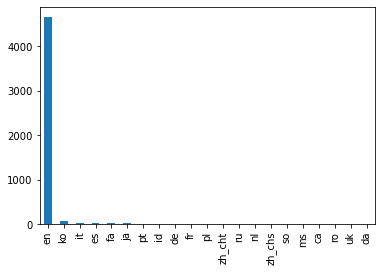

In [10]:
# LANGUAGE
# remove the non english documents

pd.value_counts(all_data_peer['language']).plot.bar()

all_data_peer_en = all_data_peer[all_data_peer['language']=='en']

print(len(all_data_peer_en))

In [11]:
# ABSTRACT
# remove the items with not abstract

# pd.value_counts(all_data_peer['language']).plot.bar()


all_data_peer_en_ab = all_data_peer_en[all_data_peer_en['abstract']!='none']
print(len(all_data_peer_en_ab))

4256


<AxesSubplot:>

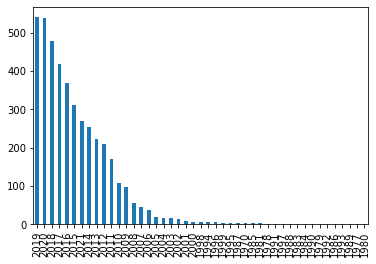

In [12]:
pd.value_counts(all_data_peer_en_ab['pub_year']).plot.bar()



In [ ]:
# create dataframe to feed into sankey generator

In [ ]:
# export filtered df to use in fixing the affiliations

## Fix Affiliation


In [31]:
all_data_peer_en_ab[all_data_peer_en_ab['affiliation']=='none']


,document_type,title,abstract,affiliation,pub_year,keywords,keywords_count,language
lens_id,,,,,,,,
063-135-016-468-50X,journal article,A Holistic Strategy for Successful Photovoltai...,<jats:p>Based on the findings from a recent st...,none,2021,none,4,en
114-765-015-990-050,journal article,A sensor-less LED dimming system based on dayl...,Artificial lighting in office buildings typica...,none,2014,none,4,en
167-492-456-423-264,journal article,Novel Designs of Photovoltaic Thermal (PV/T) S...,<jats:p>Advanced concepts of hybrid photovolta...,none,2019,none,4,en
004-008-668-058-272,journal article,System performance studies on a photovoltaic/t...,A computer simulation model is presented for t...,none,1999,none,4,en
007-309-048-277-165,journal article,Energy efficient residential house wall system,The energy consumption and greenhouse gas emis...,none,2013,none,4,en
016-172-928-740-682,journal article,Experimental study on the operating characteri...,2011-2012 > Academic research: refereed > Publ...,none,2011,none,4,en
038-711-978-531-668,journal article,Experimental Study of Electrical and Thermal E...,<jats:p>Investigating the thermal and electric...,none,2021,none,4,en
121-790-265-198-590,journal article,Efficient Photovoltaic Module Intergrated with...,<jats:p>Solar photovoltaic-thermal (PVT) is an...,none,2019,none,4,en
123-569-546-389-860,journal article,Solar timber kilns: State of the art and fores...,Analysis of the evolution in solar heated dryi...,none,2009,none,4,en


In [44]:
df_aff = all_data_peer_en_ab['affiliation'].str.split('_',n=1,expand=True)

# df_aff[df_aff[0]=='none']
# df_aff.groupby(0).nunique()
df_aff['lens_id'] = df_aff.index

df_aff[0].unique()
# df_aff[df_aff[0]=='orcid']
df_aff_lite = df_aff[df_aff[0]!='org']
df_aff_lite

,0,1,lens_id
lens_id,,,
000-161-854-690-277,magid,2967022221,000-161-854-690-277
000-408-566-376-234,magid,3016982341,000-408-566-376-234
003-172-096-379-051,orcid,0000-0001-7457-4208,003-172-096-379-051
006-388-157-210-308,magid,2231777972,006-388-157-210-308
006-571-344-800-667,magid,2791207872,006-571-344-800-667
...,...,...,...
153-906-503-422-90X,magid,2314839839,153-906-503-422-90X
163-776-305-976-717,magid,3150020972,163-776-305-976-717
176-807-166-457-888,magid,2650691927,176-807-166-457-888


In [62]:
def lookup_id(lensid, id_type, number):
    print(f'{id_type} for {number} at {lensid}')
    # time.sleep(0.5)
    if id_type=='org':
        return number
    elif id_type=='none':
        return number
    else:
        id_query = {
            
            "query": {
                "terms":{
                        "author.{}".format(id_type): [number]
                }
            }
        }

        headers = {'Authorization': token, 'Content-Type': 'application/json'}
        response = requests.post(base_url, json=id_query, headers=headers)
        if response.status_code == requests.codes.too_many_requests:
            time.sleep(6)
            print('Slowdown')
            response = requests.post(base_url, json=id_query, headers=headers)
            json_data = json.loads(response.text)
        elif response.status_code != requests.codes.ok:
            print(response.status_code)
            pass
        else:
            json_data = json.loads(response.text)
            # print(len(json_data['data']))

        affil_list = []
        
        for entries, item in enumerate(json_data['data']):
            for authors in json_data['data'][entries]['authors']:
                if 'affiliations' in json_data['data'][entries]['authors'][0].keys():
                    for author in json_data['data'][entries]['authors']:
                        if 'ids' in author.keys():
                            for id_num in author['ids']:
                                if number in id_num['value']:
                                    try:
                                        affil = author['affiliations'][0]['name']
                                        affil_list.append(affil)
                                    except KeyError:
                                        pass
                else:
                    affil_list.append('null')
        if len(list(set(affil_list))) <= 1:
            if len(affil_list)==0:
                print('empty')
                return 'null'
            elif affil_list[0]=='null':
                print('null')
                return 'null'
            else:
                return affil_list[0]
        else:
            for item in list(set(affil_list)):
                if item=='null':
                    pass
                else:
                    print(item)
                    return item

In [63]:
lens_id = '175-607-973-713-996'
id_type = 'orcid'
number = '0000-0002-5467-3695'


lookup_id(lens_id, id_type, number)

orcid for 0000-0002-5467-3695 at 175-607-973-713-996
Department of Management Sciences, Tamkang University, No. 151, Yingzhuan Rd., Danshui Dist. New Taipei City 25137, Taiwan, R.O.C.


'Department of Management Sciences, Tamkang University, No. 151, Yingzhuan Rd., Danshui Dist. New Taipei City 25137, Taiwan, R.O.C.'

In [ ]:
# this takes awhile
df_aff_lite['new'] = df_aff_lite.apply(lambda x: lookup_id(x['lens_id'], x[0], x[1]),axis=1)
df_aff_lite

In [106]:
#save a temp copy just in case 
df_aff_lite.to_csv('/Users/jmccarty/Desktop/lit_rev_affil.csv')

,document_type,title,abstract,affiliation,pub_year,keywords,keywords_count,language
lens_id,,,,,,,,
000-057-840-270-546,journal article,Photovoltaic -Thermal systems (PVT): Technolog...,Abstract Combined solar photovoltaic-thermal s...,org_Visvesvaraya National Institute of Technology,2018,"['Engineering', 'Work (electrical)', 'Systems ...",8,en
000-147-571-289-722,journal article,The multi-objective capacity optimization of w...,Abstract This paper proposes a wind-photovolta...,org_Hohai University,2020,"['Automotive engineering', 'Thermal energy sto...",10,en
000-161-854-690-277,journal article,Coloured BIPV Technologies: Methodological and...,Energy flexibility in buildings is gaining mom...,magid_2967022221,2020,"['Building-integrated photovoltaics', 'Environ...",11,en
000-214-866-666-676,journal article,Solar Tri-Generation: New Concept of Solar Ene...,It is general that each of the heat and electr...,org_National Institute of Advanced Industrial ...,2003,"['Engineering', 'Solar air conditioning', 'Gri...",11,en
000-408-566-376-234,journal article,Status of BIPV and BAPV System for Less Energy...,<jats:p>The photovoltaic (PV) system is one of...,magid_3016982341,2020,"['Building-integrated photovoltaics', 'Archite...",4,en
...,...,...,...,...,...,...,...,...
188-331-389-341-174,journal article,Numerical Investigation of the Air Flow in a N...,The natural ventilation in a novel built-in ph...,org_Donghua University,2014,"['Airflow', 'Meteorology', 'Volumetric flow ra...",11,en
193-933-367-485-686,journal article,Discuss on related issues of Buiding Integrate...,"In recent years,the Buiding Integrated PV(BIPV...",org_Center of Science and Technology of Constr...,2011,"['Building-integrated photovoltaics', 'Enginee...",8,en
195-551-080-364-069,journal article,Experimental Study of Photovoltaic/Thermal Sol...,A new type of photovoltaic/thermal(PV/T) was d...,org_Dalian University of Technology,2012,"['Nuclear engineering', 'Engineering', 'Experi...",11,en


In [179]:
df_aff_lite
all_data_peer_en_ab

new_df = pd.concat([all_data_peer_en_ab,df_aff_lite],axis=1)
# all_data_peer_en_ab
new_df = new_df.join(df_url)


In [181]:

# df_aff_lite
def create_affiliation_col(affil,new_affil):
    if 'org_' in affil:
        affiliation = affil.split('_',maxsplit=1)[1]
        return affiliation
    elif 'none' in affil:
        return 'null'
    else:
        return new_affil
    
new_df['affiliation2'] = new_df.apply(lambda x: create_affiliation_col(x['affiliation'],x['new']),axis=1)
new_df.sample(5)


,document_type,title,abstract,affiliation,pub_year,keywords,keywords_count,language,0,1,lens_id,new,External URL,affiliation2
lens_id,,,,,,,,,,,,,,
027-264-431-719-973,journal article,Modeling and simulation of a photovoltaic/ther...,Abstract Integration of photovoltaic/thermal a...,org_Concordia University Wisconsin,2017,"['Engineering', 'Heating element', 'Modeling a...",11,en,NaN,NaN,NaN,NaN,http://dx.doi.org/10.1016/j.enbuild.2017.05.045,Concordia University Wisconsin
019-345-868-881-206,journal article,An Experimental Comparison of two Solar Photov...,Two solar photovoltaic-thermal (PVT) energy co...,magid_1999290893,2012,"['Solar mirror', 'Nuclear engineering', 'Solar...",11,en,magid,1999290893,019-345-868-881-206,Ulster University,http://dx.doi.org/10.5923/j.ep.20120204.01,Ulster University
002-020-135-983-456,journal article,Solar radiation transfer and performance analy...,"In this study, we investigated a concentrating...",org_Dalian University of Technology,2015,"['Solar mirror', 'Solar air conditioning', 'Na...",10,en,NaN,NaN,NaN,NaN,http://dx.doi.org/10.1002/ep.12196,Dalian University of Technology
028-603-238-273-420,journal article,Investigation on a spectral splitting photovol...,The present work developed a spectral splittin...,org_Tongji University,2016,"['Thermal energy', 'Work (thermodynamics)', 'M...",11,en,NaN,NaN,NaN,NaN,http://dx.doi.org/10.1016/j.renene.2015.08.080,Tongji University
078-153-924-061-135,journal article,Near-neutral-colored semitransparent perovskit...,Organo-lead-halide perovskite based solar cell...,org_Tsinghua University,2017,"['Etching (microfabrication)', 'Plasma etching...",10,en,NaN,NaN,NaN,NaN,http://dx.doi.org/10.1016/j.solmat.2016.10.035,Tsinghua University


## Export Final File
 - cleanup naming
 - save to csv

In [186]:
columns = ['document_type',
            'title',
            'abstract',
            'affiliation2',
            'pub_year',
            'keywords',
            'External URL']
final_df = new_df[columns].copy()
final_df = final_df.rename(columns={'affiliation2':'affiliation',
                                    'pub_year':'year',
                                    'document_type':'type',
                                    'External URL':'source'})

# some abstract had either the word Abstract or an html tag <jats:p> in them
final_df['abstract'] = final_df['abstract'].str.replace('Abstract', '')
final_df['abstract'] = final_df['abstract'].str.replace('<jats:p>', '')
final_df



,type,title,abstract,affiliation,year,keywords,source
lens_id,,,,,,,
000-057-840-270-546,journal article,Photovoltaic -Thermal systems (PVT): Technolog...,Combined solar photovoltaic-thermal systems (...,Visvesvaraya National Institute of Technology,2018,"['Engineering', 'Work (electrical)', 'Systems ...",http://dx.doi.org/10.1016/j.rser.2018.04.067
000-147-571-289-722,journal article,The multi-objective capacity optimization of w...,This paper proposes a wind-photovoltaic-therm...,Hohai University,2020,"['Automotive engineering', 'Thermal energy sto...",http://dx.doi.org/10.1016/j.solener.2019.11.063
000-161-854-690-277,journal article,Coloured BIPV Technologies: Methodological and...,Energy flexibility in buildings is gaining mom...,Polytechnic University of Milan,2020,"['Building-integrated photovoltaics', 'Environ...",http://dx.doi.org/10.3390/en13174506
000-214-866-666-676,journal article,Solar Tri-Generation: New Concept of Solar Ene...,It is general that each of the heat and electr...,National Institute of Advanced Industrial Scie...,2003,"['Engineering', 'Solar air conditioning', 'Gri...",http://dx.doi.org/10.1115/isec2003-44218
000-408-566-376-234,journal article,Status of BIPV and BAPV System for Less Energy...,The photovoltaic (PV) system is one of the mos...,null,2020,"['Building-integrated photovoltaics', 'Archite...",http://dx.doi.org/10.3390/app10072337
...,...,...,...,...,...,...,...
188-331-389-341-174,journal article,Numerical Investigation of the Air Flow in a N...,The natural ventilation in a novel built-in ph...,Donghua University,2014,"['Airflow', 'Meteorology', 'Volumetric flow ra...",NaN
193-933-367-485-686,journal article,Discuss on related issues of Buiding Integrate...,"In recent years,the Buiding Integrated PV(BIPV...",Center of Science and Technology of Constructi...,2011,"['Building-integrated photovoltaics', 'Enginee...",https://en.cnki.com.cn/Article_en/CJFDTOTAL-NC...
195-551-080-364-069,journal article,Experimental Study of Photovoltaic/Thermal Sol...,A new type of photovoltaic/thermal(PV/T) was d...,Dalian University of Technology,2012,"['Nuclear engineering', 'Engineering', 'Experi...",https://en.cnki.com.cn/Article_en/CJFDTOTAL-JZ...


In [187]:
# save dataset to file
final_df.to_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/lit_dataset_clean.csv')